# Description of the code: 

In [1]:
from segmentation import segment_image, init_image, alienlab
p = alienlab.plot.ShowFigure()
p.save_folder = "results/"
p.fontsize=18
p.fonttick=12
p.date = False
p.extension = ".pdf"
import pickle as pk
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

from joblib import Parallel

from useful_func import *


from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from scipy.ndimage import binary_erosion

from matplotlib.colors import ListedColormap, Normalize


import tifffile as tiff
from tqdm import tqdm

sigma_480 = 198 #m2/mol
sigma_405 = 415 #m2/mol
tau_relax = 0.014

import click

import CSLtools.CSLtools as CSLtools

import incense
from incense import ExperimentLoader

#source: incense github page

def get_mongo_uri():
    in_devcontainer = (
        os.environ.get("TERM_PROGRAM") == "vscode"
        or os.environ.get("HOME") == "/home/vscode"
        or (os.environ.get("PATH") or "").startswith("/home/vscode")
    )
    if in_devcontainer:
        return "mongodb://mongo:27017"
    else:
        return None



loader = ExperimentLoader(
    mongo_uri=get_mongo_uri(), 
    db_name='sacred'
)

#%matplotlib widget

In [3]:
idi = 41 #623
exp = loader.find_by_id(idi)
video = tiff.imread(exp.artifacts["video.tiff"].file)
save_folder = glob.glob("D:/github/CSL-forge/Experiments/%d_*"%idi)[0]
timing = exp.metrics["Time"]

In [4]:
video.max()


79.08

<Figure size 640x480 with 0 Axes>

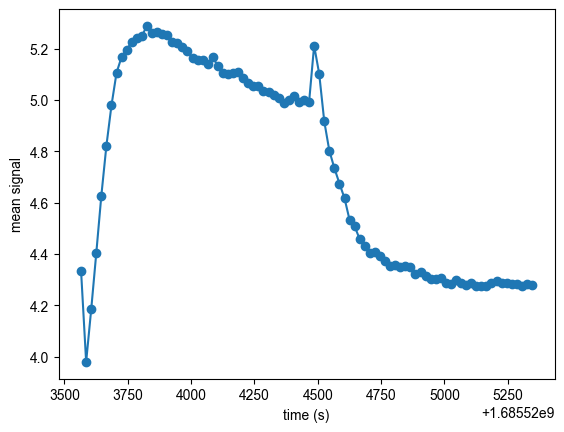

<Figure size 640x480 with 0 Axes>

In [5]:

framerate = 1/(timing[1]-timing[0])

plt.xlabel('time (s)')
plt.ylabel('mean signal')
x = timing
y= np.mean(video[0:], axis = (1,2))
plt.plot(x[y>2], y[y>2], "-o")
plt.figure()


exception calling callback for <Future at 0x1b08ae7da90 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\alien\Anaconda3\envs\cslforge\lib\site-packages\joblib\parallel.py", line 862, in dispatch_one_batch
    tasks = self._ready_batches.get(block=False)
  File "C:\Users\alien\Anaconda3\envs\cslforge\lib\queue.py", line 167, in get
    raise Empty
_queue.Empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\alien\Anaconda3\envs\cslforge\lib\site-packages\joblib\externals\loky\_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "C:\Users\alien\Anaconda3\envs\cslforge\lib\site-packages\joblib\parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\alien\Anaconda3\envs\cslforge\lib\site-packages\joblib\parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\alien\Anaconda3\env

--- Computed binary mask in 14.882298 seconds ---


exception calling callback for <Future at 0x1b08bd3bb20 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\alien\Anaconda3\envs\cslforge\lib\site-packages\joblib\parallel.py", line 862, in dispatch_one_batch
    tasks = self._ready_batches.get(block=False)
  File "C:\Users\alien\Anaconda3\envs\cslforge\lib\queue.py", line 167, in get
    raise Empty
_queue.Empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\alien\Anaconda3\envs\cslforge\lib\site-packages\joblib\externals\loky\_base.py", line 26, in _invoke_callbacks
    callback(self)
  File "C:\Users\alien\Anaconda3\envs\cslforge\lib\site-packages\joblib\parallel.py", line 385, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\alien\Anaconda3\envs\cslforge\lib\site-packages\joblib\parallel.py", line 834, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\alien\Anaconda3\env

--- Computed binary mask in 16.737380 seconds ---


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--- Computed segmentation in 1.225723 seconds ---


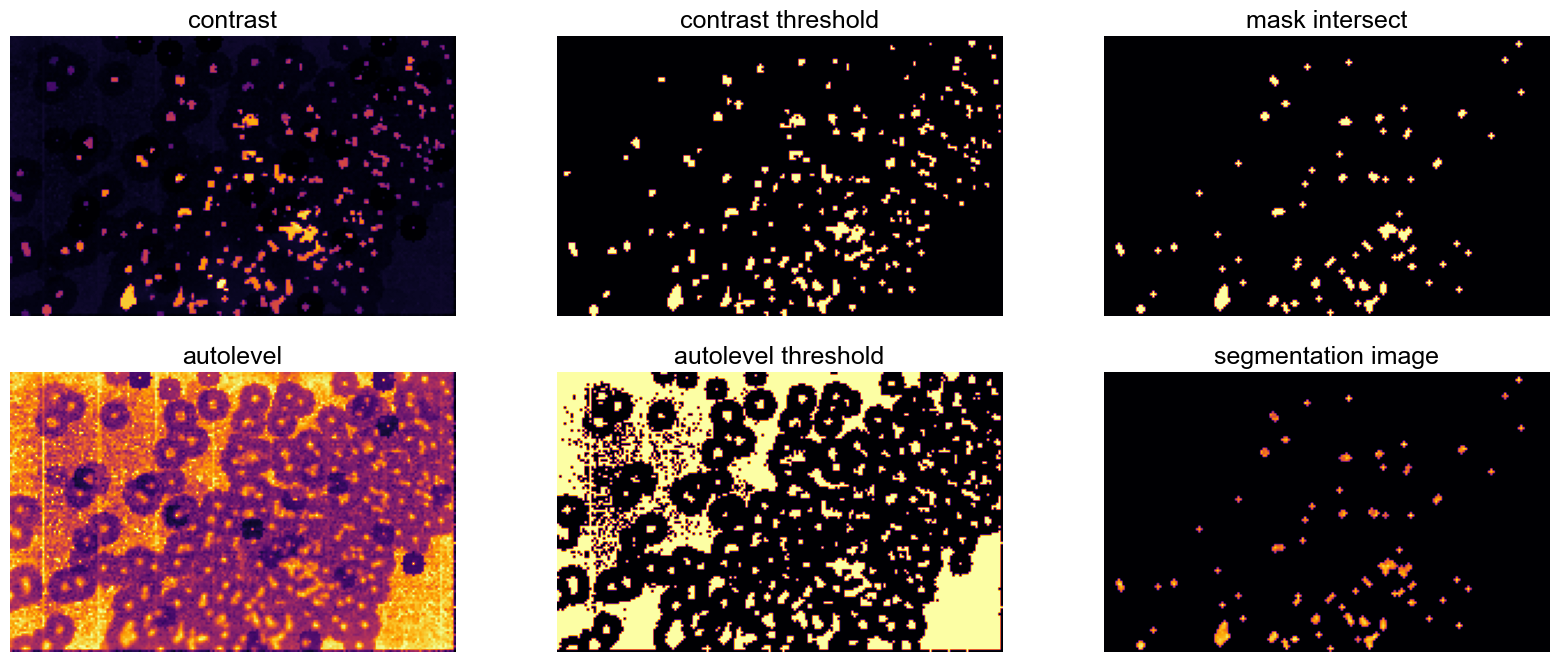

<Figure size 640x480 with 0 Axes>

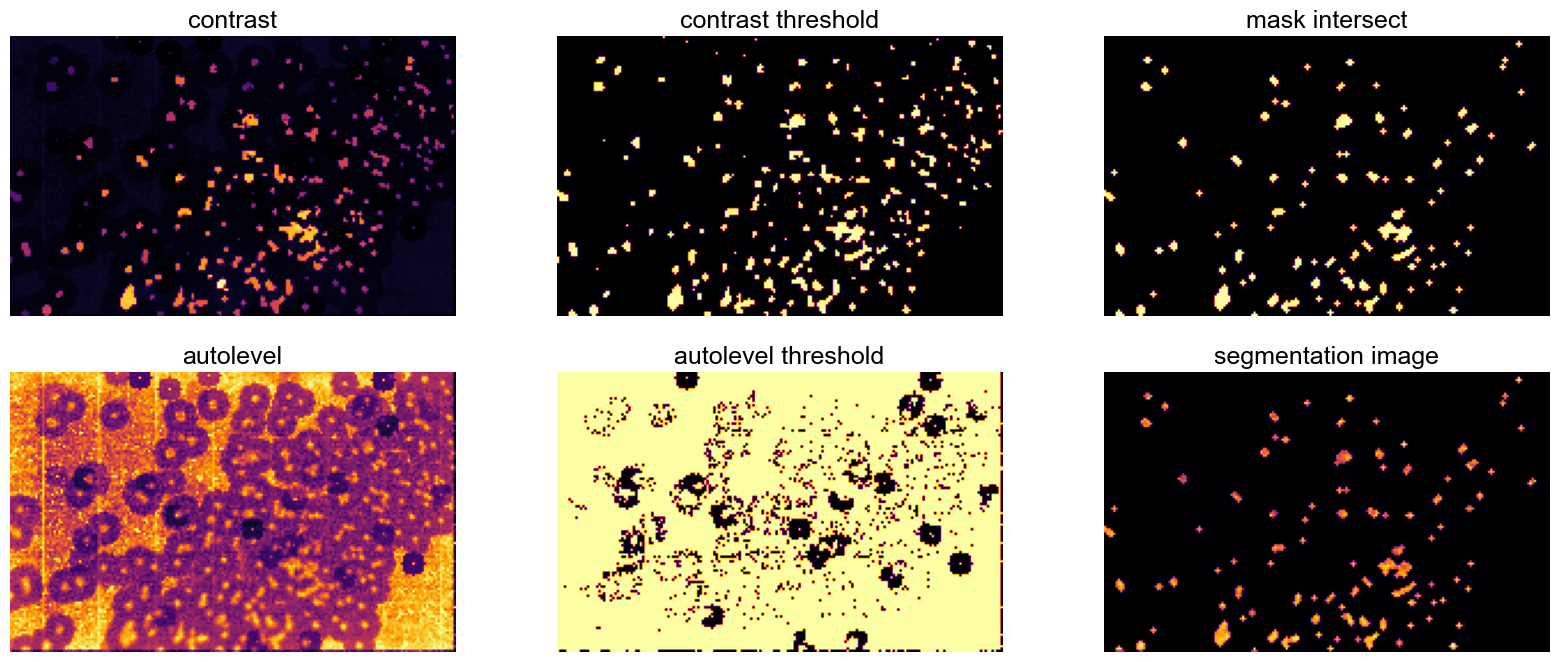

<Figure size 640x480 with 0 Axes>

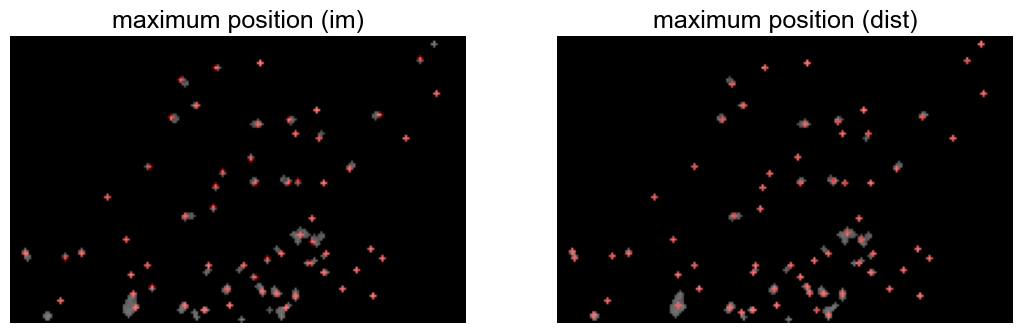

<Figure size 640x480 with 0 Axes>

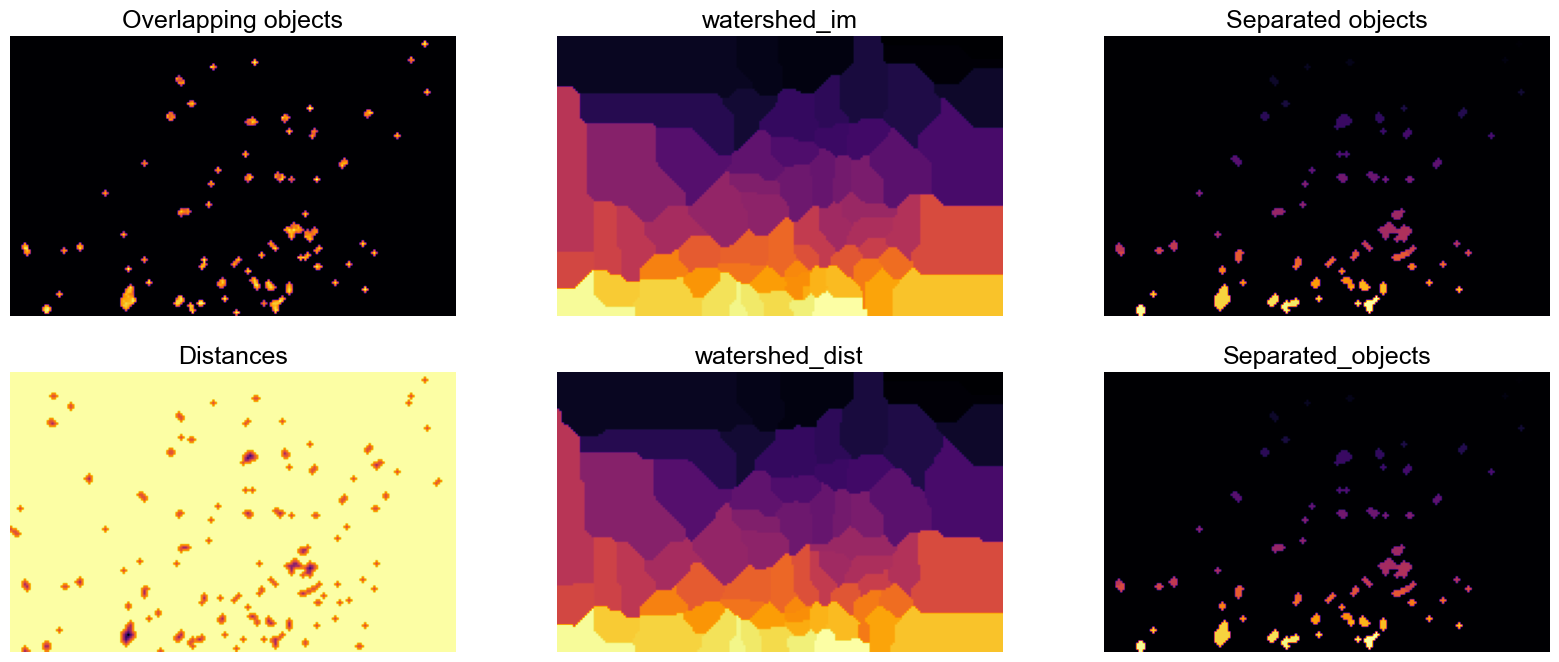

<Figure size 640x480 with 0 Axes>

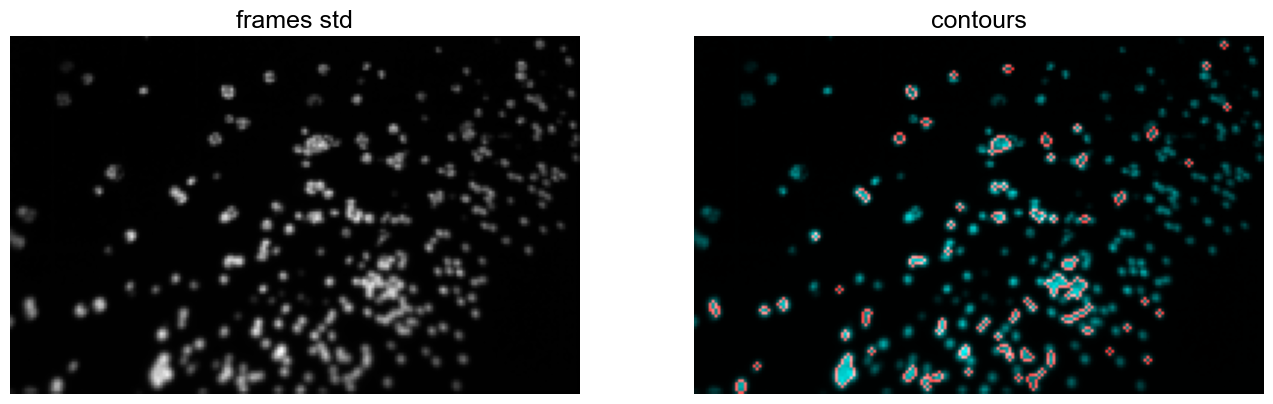

<Figure size 640x480 with 0 Axes>

In [6]:
file = glob.glob(save_folder + "/video.tiff")[0]

FO = init_image(file)
FO.frames = FO.frames/255
p.save_folder= save_folder
watershed_im_mask, FO    = segment_image(FO, contrast = 6, autolevel = 5, dist_max = True, dist_seg=True, disk_size = 1, max_contrast = 3, interact = False, showit= True)  
np.save(save_folder + "/labels.npy", watershed_im_mask)

In [7]:

file = glob.glob(save_folder + "/video.tiff")[0]

labels = glob.glob(save_folder + "/labels.npy")[0]

segmented = np.load(labels)
FO = init_image(file)

items = np.unique(segmented) #returns the set of values in items, corresponds to the values of the markers of local_maxima

items_dict = {}
for k in items:
    key = str(k)
    items_dict[key] = {}
    x_coords, y_coords = np.nonzero(segmented == k)
    items_dict[key]['x_coords'] = x_coords
    items_dict[key]['y_coords'] = y_coords
    pixel_values = FO.frames[:,x_coords, y_coords]
    items_dict[key]['pixel_values'] = pixel_values
    items_dict[key]['surface'] = pixel_values.shape[1]
    items_dict[key]['mean'] = np.mean(pixel_values, axis = 1)
    items_dict[key]['std'] = np.std(pixel_values, axis = 1)
    items_dict[key]['remains'] = True
    
np.save(save_folder + "/items_dict.npy", items_dict)

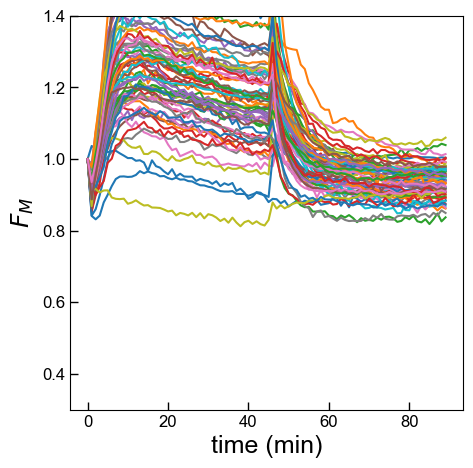

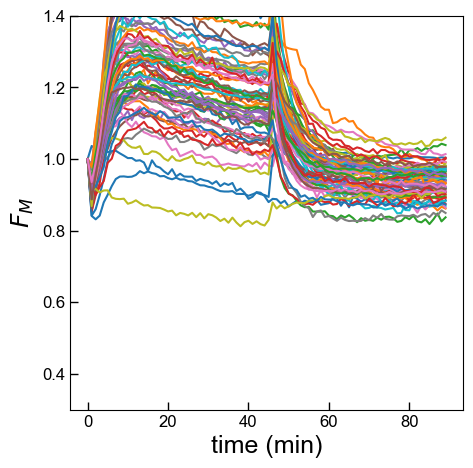

<Figure size 640x480 with 0 Axes>

In [8]:
p = alienlab.plot.PlotFigure()
p.save_folder = "results/"
p.fontsize=18
p.fonttick=12
p.date = False
p.extension = ".pdf"

p.ylabel ="$F_M$"
p.xlabel = "time (min)"

fig0 = p.set_figure("%d", "%0.1f")
ax0 = plt.gca()
plt.ylim(0.3, 1.4)

y_list = []

for i, folder in enumerate([save_folder]):
    
        file =np.load(glob.glob(folder + "/items_dict.npy")[0], allow_pickle=True).item()
        for key in file.keys():
            y = file[key]["mean"]
            y=y[259::20]
            plt.plot(y/y[0])
            y_list.append(np.append(y, y[-1]))
            
p.save_name = "SP_check_calib_0"
p.saving(fig0)


In [9]:
def transform_data(arr, dict_learner, M_lda, S_lda, Tr, R, origin):
    arr = arr/np.expand_dims(np.sum(arr, axis = 1),1)
    data = dict_learner.transform(arr)
    data = (data - M_lda[:,0])/S_lda[:,0]
    X = np.dot(data,Tr)
    X =  np.dot(X, R.T)
    X = X-origin[:,0]

    #X[:,2] = -X[:,2]
    #X[:,1] = -X[:,1]
    #X[:,0] = -X[:,0]
    return X



with open("../data/dico.pkl", "rb") as file:
    dict_learner = pk.load(file)

M_dict = np.array(pd.read_csv("../data/dict_array_M_dict.csv", sep = " ", header = None))
S_dict = np.array(pd.read_csv("../data/dict_array_S_dict.csv", sep = " ", header = None))

M_lda = np.array(pd.read_csv("../data/dict_array_M_lda.csv",  sep = " ", header = None))
S_lda = np.array(pd.read_csv("../data/dict_array_S_lda.csv",  sep = " ", header = None))

Tr = np.array(pd.read_csv("../data/dict_array_Tr.csv",  sep = " ", header = None))
R = np.array(pd.read_csv("../data/dict_array_R.csv",  sep = " ", header = None))
origin = np.array(pd.read_csv("../data/dict_array_origin.csv", sep = " ", header = None))

y_array = np.array(y_list)
y_tr = transform_data(y_array, dict_learner, M_lda, S_lda, Tr, R, origin)
np.save(save_folder + "/projection_dict_lda.npy", y_tr)

C:\Users\alien\Anaconda3\envs\cslforge\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MiniBatchDictionaryLearning from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


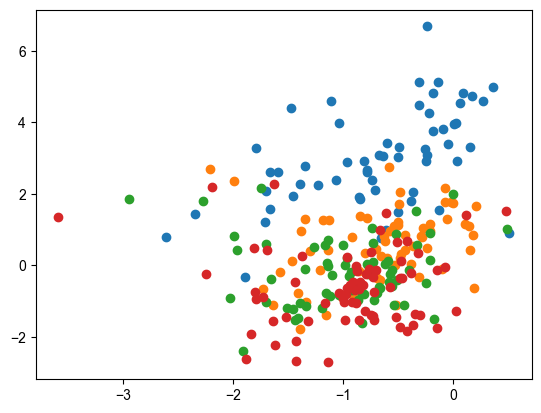

In [12]:
for idi in [40, 41, 42, 43]:
    save_folder = glob.glob("D:/github/CSL-forge/Experiments/%d_*"%idi)[0]
    
    y_tr =np.load(glob.glob(save_folder + "/projection_dict_lda.npy")[0], allow_pickle=True)
    plt.scatter(y_tr[:,1], y_tr[:,2])